## Part 2

- For the same person from step 1), use the Wikipedia API to access the whole content of that person's Wikipedia page.
- The goal of part 2) is to produce the capability to:
  1. For that Wikipedia page determine the sentiment of the entire page
  1. Print out the Wikipedia article
  1. Collect the Wikipedia pages from the 10 nearest neighbors in Step 1)
  1. Determine the nearness ranking of these 10 to your main subject based on their entire Wikipedia page
  1. Compare the nearest ranking from Step 1) with the Wikipedia page nearness ranking

In [49]:
%%capture  
%pip install wikipedia  # Install the wikipedia package
%sudo apt install beautifulsoup4

import wikipedia  # Import the wikipedia library
import pandas as pd  # Import pandas for data manipulation
import numpy as np  # Import numpy for numerical operations
import matplotlib.pyplot as plt  # Import matplotlib for plotting data
import seaborn as sns  # Import seaborn for advanced visualizations
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer  # Import vectorizers for converting text data into numerical form
from sklearn.metrics.pairwise import cosine_similarity  # Import cosine_similarity for calculating similarity between vectors
from sklearn.decomposition import TruncatedSVD  # Import TruncatedSVD for dimensionality reduction
from sklearn.neighbors import NearestNeighbors  # Import NearestNeighbors for finding nearest points
from sklearn.decomposition import TruncatedSVD  # Re-importing TruncatedSVD (unnecessary duplication)
import BeautifulSoup  # Import BeautifulSoup for HTML parsing

import nltk  # Import NLTK library for natural language processing
nltk.download('punkt')  # Download the punkt tokenizer
nltk.download('averaged_perceptron_tagger')  # Download POS tagger
nltk.download('wordnet')  # Download WordNet for lexical database
nltk.download('stopwords')  # Download stopwords library

from textblob import TextBlob, Word, Blobber  # Import TextBlob and its components for text processing and sentiment analysis

In [50]:
def get_wikipedia_content(person_name):
    # Attempt to retrieve the Wikipedia page for the given person name
    try:
        page = wikipedia.page(person_name)
        # If successful, return the content of the page
        return page.content
    except wikipedia.exceptions.PageError:
        # If a PageError occurs (e.g., page not found), return None
        return None



In [51]:
def clean_text(text):
    # Convert text to lowercase
    text = text.lower()
    # Split text into individual words
    words = text.split()
    # Singularize each word
    singularized_words = [Word(word).singularize() for word in words]
    # Join singularized words back into a single string
    return ' '.join(singularized_words)

In [52]:
def analyze_wikipedia_content(person_name, nearest_neighbors):
    # Retrieve the main content from Wikipedia for the given person_name
    main_content = get_wikipedia_content(person_name)
    

    # Check if the content was successfully retrieved
    if main_content is None:
        print(f"No Wikipedia page found for {person_name}")
        return None, None, None, None
    

    # Clean the main Wikipedia content
    main_content = clean_text(main_content)
    

    neighbor_contents = []
    # Iterate over each neighbor to get and clean their Wikipedia content
    for neighbor in nearest_neighbors:
        content = get_wikipedia_content(neighbor)
        if content is not None:
            neighbor_contents.append(clean_text(content))
    

    # Ensure there is enough neighbor data to perform analysis
    if len(neighbor_contents) < 2:
        print("Not enough data to perform analysis. Skipping ranking.")
        return None, None, None, None
    

    # Create a bag-of-words vectorizer and transform the content
    bow_vectorizer = CountVectorizer(stop_words='english')
    bow_matrix = bow_vectorizer.fit_transform([main_content] + neighbor_contents)

    # Create a TF-IDF vectorizer and transform the content
    tfidf_vectorizer = TfidfVectorizer(stop_words='english')
    tfidf_matrix = tfidf_vectorizer.fit_transform([main_content] + neighbor_contents)
    

    # Calculate cosine similarity using the bag-of-words model
    bow_similarity = cosine_similarity(bow_matrix[0].reshape(1, -1), bow_matrix[1:])
    # Calculate cosine similarity using the TF-IDF model
    tfidf_similarity = cosine_similarity(tfidf_matrix[0].reshape(1, -1), tfidf_matrix[1:])
    

    # Rank neighbors based on bag-of-words similarity scores
    bow_ranking = np.argsort(bow_similarity[0])[::-1]
    # Rank neighbors based on TF-IDF similarity scores
    tfidf_ranking = np.argsort(tfidf_similarity[0])[::-1]
    

    # Create lists of neighbor names ranked by similarity
    bow_wikipedia_ranking = [nearest_neighbors[i] for i in bow_ranking]
    tfidf_wikipedia_ranking = [nearest_neighbors[i] for i in tfidf_ranking]
    

    # Return the main content, ranked lists, and the TF-IDF matrix
    return main_content, bow_wikipedia_ranking, tfidf_wikipedia_ranking, tfidf_matrix


In [53]:
# Define the target person's name
person_name = "Porta Rapper"
# List of nearest neighbor names for comparison
nearest_neighbors = ['the game rapper', 'stacie orrico', 'keyshia cole', 'princess singer', 'rob zombie', 'roy hay musician', 'grant campbell musician', 'grant campbell musician', 'nina vidal', 'kate walsh singer']

# Analyze Wikipedia content for target person and nearest neighbors
main_content, bow_wikipedia_ranking, tfidf_wikipedia_ranking, tfidf_matrix = analyze_wikipedia_content(person_name, nearest_neighbors)

# Check if main content is found
if main_content is not None:
    # Display rankings based on Bag of Words (BoW) method
    print(f"\nBoW Ranking:")
    for i, neighbor in enumerate(bow_wikipedia_ranking):
        print(f"{i+1}. {neighbor}")

    # Display rankings based on TF-IDF method
    print("\nTF-IDF Ranking:")
    for i, neighbor in enumerate(tfidf_wikipedia_ranking):
        print(f"{i+1}. {neighbor}")

    # Visualization
    # Perform dimensionality reduction for visualization
    svd = TruncatedSVD(n_components=2, random_state=42)
    X_svd = svd.fit_transform(tfidf_matrix)


BoW Ranking:
1. the game rapper
2. roy hay musician
3. grant campbell musician
4. stacie orrico
5. princess singer
6. keyshia cole
7. rob zombie
8. nina vidal
9. grant campbell musician

TF-IDF Ranking:
1. the game rapper
2. stacie orrico
3. grant campbell musician
4. roy hay musician
5. keyshia cole
6. princess singer
7. nina vidal
8. rob zombie
9. grant campbell musician


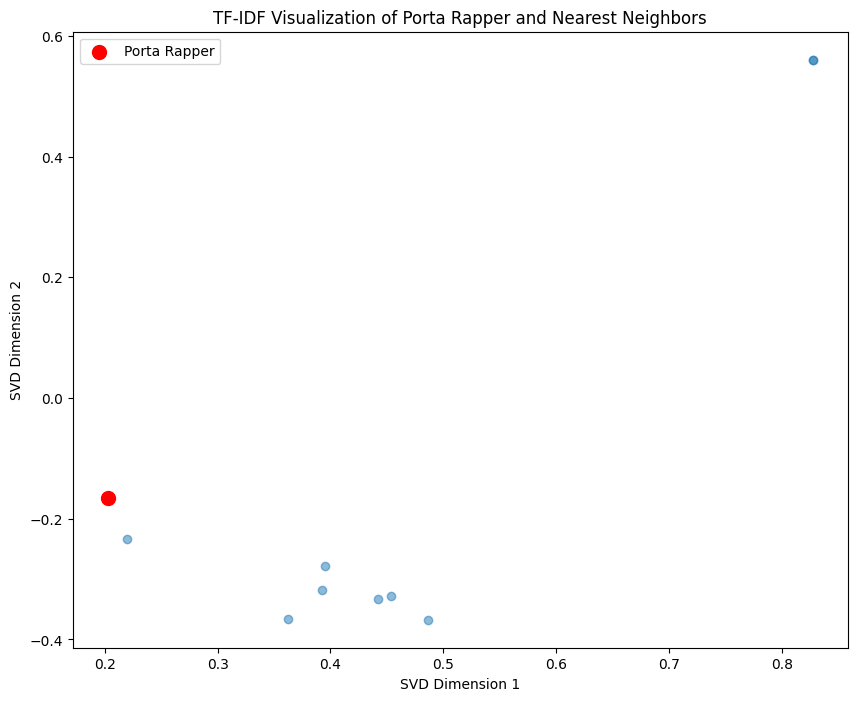


Sentiment of Porta Rapper's Wikipedia page:
Polarity: 0.11818181818181818
Subjectivity: 0.29090909090909095

Wikipedia article for Porta Rapper:
christian jiménez bundo (born 2 july 1988 in barcelona), known professionally a porta, is a spanish rapper. == early life and education == he wa born in sarrià, barcelona. == career == hi lyric have sometime been controversial, and have been criticised by the instituto nacional de la mujere (national association of women). at a concert he put on in 2008 at fórum de la fnac in a coruña, there wa fighting in the audience between hi supporter and those who disliked him. portum won a neox fan award ...

Comparison of rankings:
the game rapper: Original rank 1, Wikipedia rank 1
stacie orrico: Original rank 2, Wikipedia rank 2
keyshia cole: Original rank 3, Wikipedia rank 5
princess singer: Original rank 4, Wikipedia rank 6
rob zombie: Original rank 5, Wikipedia rank 8
roy hay musician: Original rank 6, Wikipedia rank 4
grant campbell musician: Ori

In [ ]:
plt.figure(figsize=(10, 8))  # Create a new figure with specific dimensions
plt.scatter(X_svd[1:, 0], X_svd[1:, 1], alpha=0.5)  # Plot scatter of all points except the first with transparency
plt.scatter(X_svd[0, 0], X_svd[0, 1], color='red', s=100, label=person_name)  # Highlight the first point in red with a label
plt.title(f"TF-IDF Visualization of {person_name} and Nearest Neighbors")  # Set the title of the plot
plt.xlabel("SVD Dimension 1")  # Label for x-axis
plt.ylabel("SVD Dimension 2")  # Label for y-axis
plt.legend()  # Show legend on plot
plt.show()  # Display the plot

    # Calculate sentiment of the entire page
main_sentiment = TextBlob(main_content).sentiment  # Analyze the sentiment of the main content using TextBlob
print(f"\nSentiment of {person_name}'s Wikipedia page:")  # Print heading for sentiment analysis
print(f"Polarity: {main_sentiment.polarity}")  # Print the polarity of the sentiment
print(f"Subjectivity: {main_sentiment.subjectivity}")  # Print the subjectivity of the sentiment

    # Print out the Wikipedia article
print(f"\nWikipedia article for {person_name}:")  # Print heading for Wikipedia article content
print(main_content[:500] + "...")  # Print the first 500 characters of the article followed by ellipsis

    # Compare rankings
original_ranking = nearest_neighbors  # Assign nearest_neighbors to original_ranking for comparison
print("\nComparison of rankings:")  # Print heading for rankings comparison
for i in range(len(original_ranking)):  # Iterate over each item in the original ranking
        if original_ranking[i] in tfidf_wikipedia_ranking:  # Check if item exists in TF-IDF ranking
            print(f"{original_ranking[i]}: Original rank {i+1}, Wikipedia rank {tfidf_wikipedia_ranking.index(original_ranking[i])+1}")  # Print ranks
        else:  # If item not in TF-IDF ranking
            print(f"{original_ranking[i]}: Original rank {i+1}, Not found in Wikipedia ranking")  # Indicate not found
else:  # If no original ranking
    print(f"No Wikipedia page found for {person_name}. Unable to perform analysis.")  # Print failure message if Wikipedia page not found